# House prices predictions

## Feature analysis 

- Regressione classica
- Feature reduction (PCA, SVD)
- Clustering alle case (togliendo prezzo)
- cross validation or hold-out

In [36]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [37]:
houses = pd.read_csv("../datasets/house_prices/train.csv")
houses = houses._get_numeric_data().dropna(axis=1)
houses = houses.drop(['Id'], axis=1)
#see how big the df has become
houses.shape

(1460, 34)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

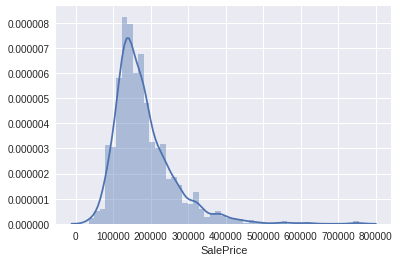

In [38]:
sns.distplot(houses['SalePrice']);
houses['SalePrice'].describe()

Analizzo mappa di calore:

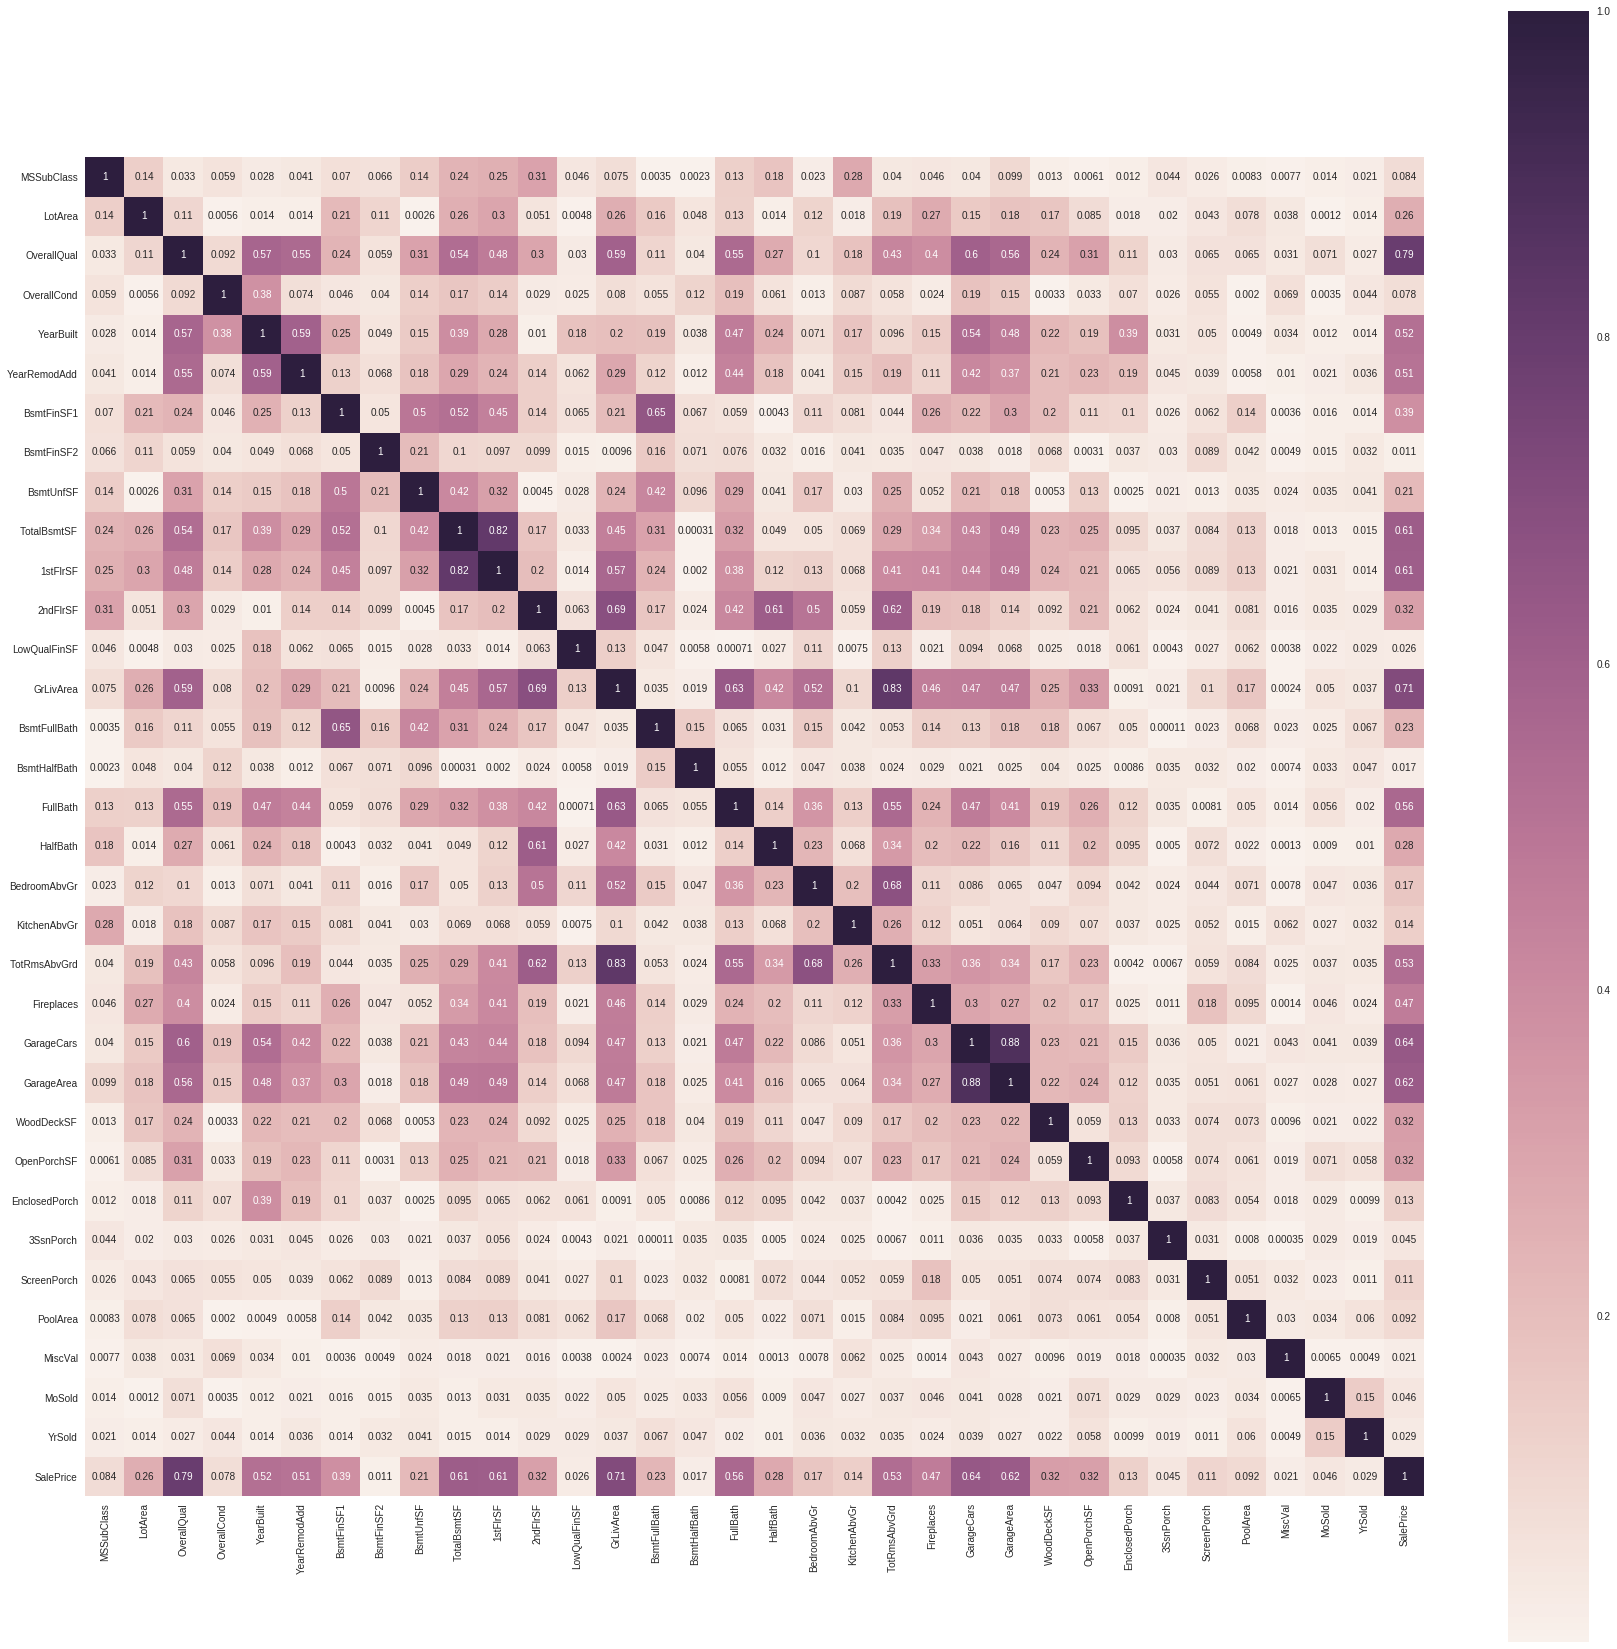

In [39]:
corrmat = houses.corr().abs()
f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, annot=True, square=True);

Seleziono le features con correlazione >0.75:

In [40]:
soglia = 0.75
s = corrmat.unstack()
best_features = s[s<1].sort_values()[s>soglia]
l1, l2 = zip(*best_features.index.tolist())
name_best_features = list(set(l1).intersection(l2))
print("Le features con correlazione > "+str(soglia)+" sono: ")
best_features


Le features con correlazione > 0.75 sono: 


OverallQual   SalePrice       0.790982
SalePrice     OverallQual     0.790982
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
dtype: float64

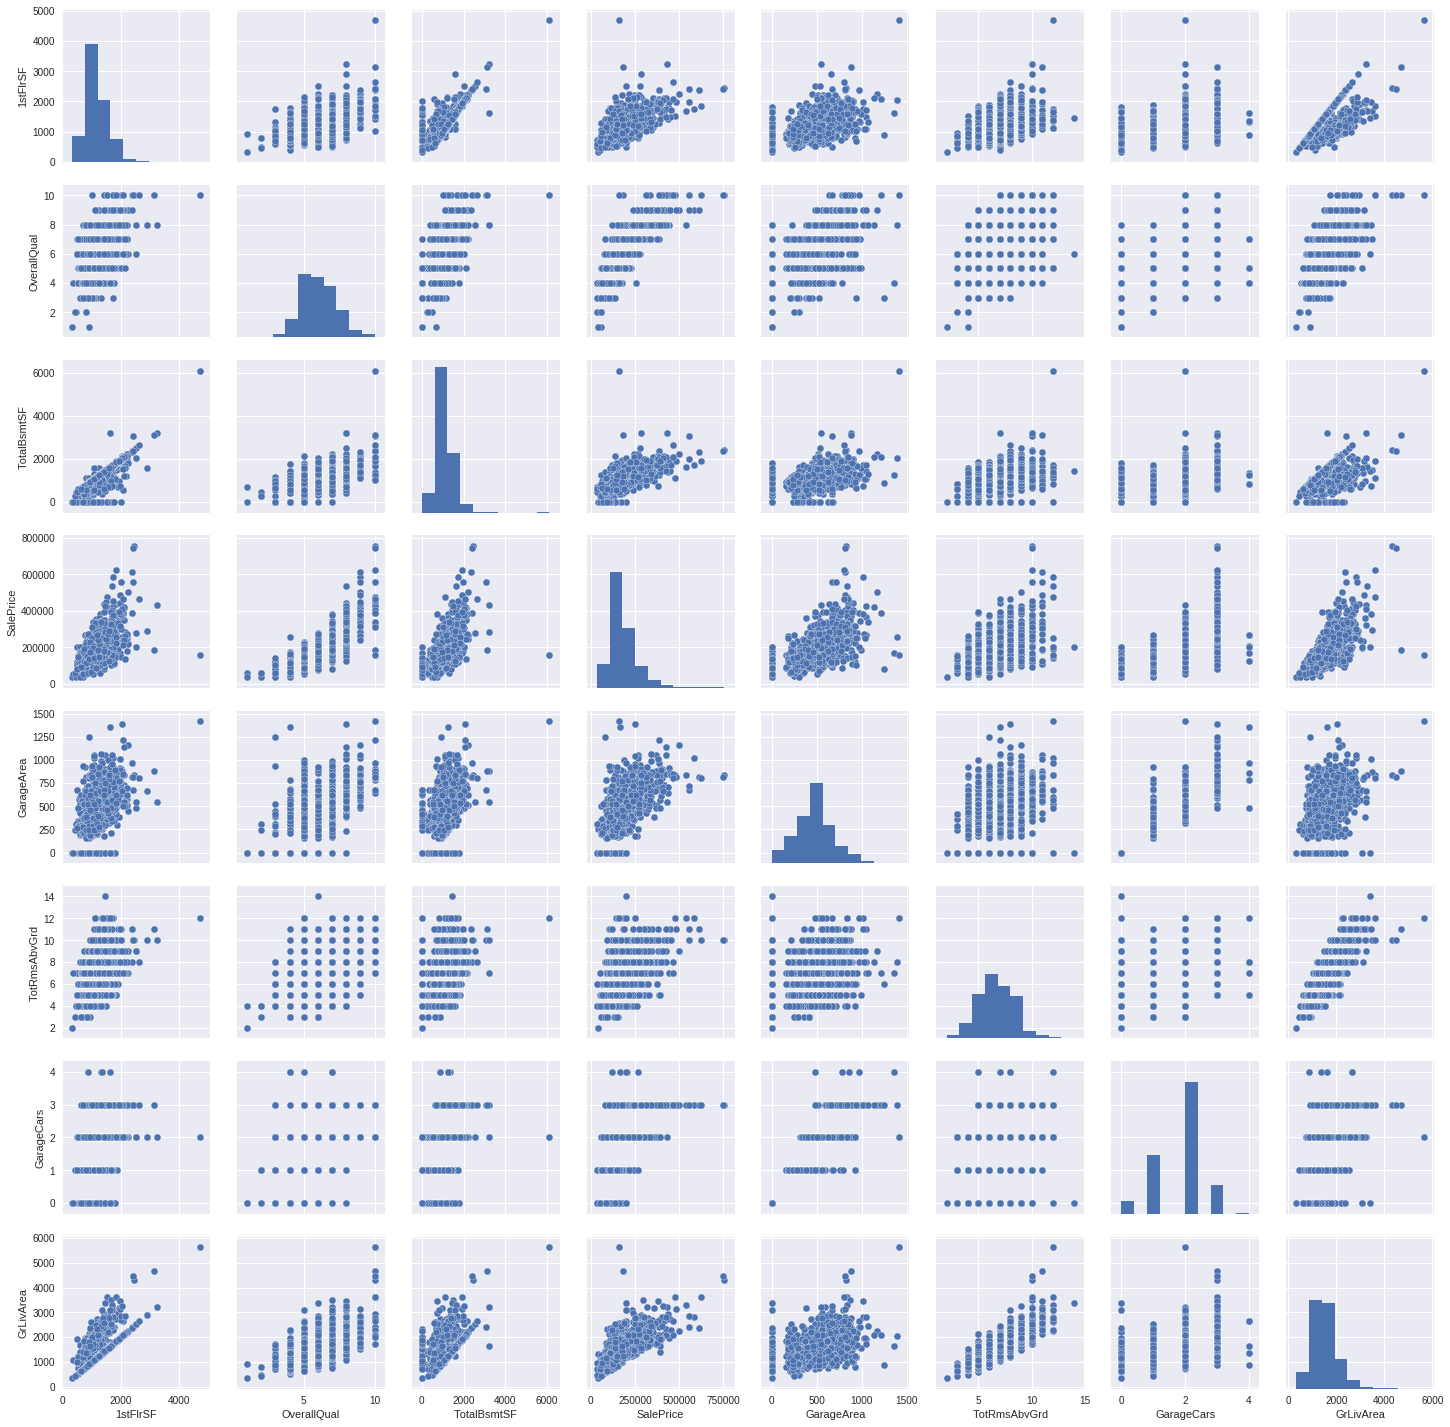

In [5]:
#scatterplot
sns.set()
sns.pairplot(houses[name_best_features], size = 2.5)
plt.show();

In [41]:
#let's select the features with highest correlation wrt the attribute 'SalePrice'
saleCorr = corrmat['SalePrice']
highest_corr_feats = saleCorr.nlargest(10)
highest_corr_feats

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

As we can notice from the results, we picked the data with higher correlation wrt to the target attribute.
There are a couple of things that we may consider:
- as we expected OverallQual and GrLivArea are the dominant values for the price, but pretty surprisingly we don't find Neighborhood even though it's reasonable to think the the price of a house should also depends on that  
- GarageCars and GarageArea have a similar correlation that's probably because they are the same thing i.e. the numbers of cars it's strictly dependent on how big a garage is, so we may consider to drop one of those features cause there are both telling us the same thing


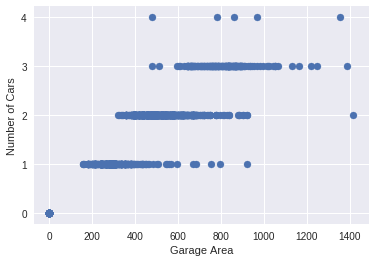

In [42]:
#let's make sure of the relation between GarageCars and GarageArea with a simple scatterplot
x_axis = houses['GarageArea']
y_axis = houses['GarageCars']
plt.scatter(x_axis,y_axis)
plt.xlabel('Garage Area')
plt.ylabel('Number of Cars')
plt.yticks(np.arange(0,5))
plt.show()

Not as much as we expected but there is still a tendence about the relation we said.

### Regressione lineare

In [43]:
# Split the data into training/testing sets
#houses_X_train = houses_X[:-20]
#houses_X_test = houses_X[-20:]

# Split the targets into training/testing sets
#houses_y_train = houses_y[:-20]
#houses_y_test = houses_y[-20:]

#let's stick all together in a function in order to be able to use it all over the notebook

def linRegr(model, iterations, df, test_size):
    tot_score = 0.
    tot_rmse = 0.
    for i in range(iterations):
        train, test = train_test_split(df, test_size=test_size)
    
        X_train = train.drop(['SalePrice'], axis=1)
        y_train = train['SalePrice']
        X_test = test.drop([ 'SalePrice'], axis=1)
        y_test = test['SalePrice']    
    
        # Train the model using the training sets
        model.fit(X_train, y_train)

        # Coefficients: this is the m term in the formula f(x) = mx + q
        #print('Coefficients: \n', regr.coef_, regr.intercept_)
        # Mean squared error
        rmse = mean_squared_error(y_test, model.predict(X_test))**0.5
        print("Root mean squared error: %.2f"% rmse)
        # Explained variance score: 1 is perfect prediction
        score = model.score(X_test, y_test)
        print('Variance score: %.2f' % score)
        tot_rmse += rmse
        tot_score += score
    
    print('\nAverage score: %.2f' % float(tot_score/iterations))
    print('Average rmse: %.2f' % float(tot_rmse/iterations))    

In [48]:
#using the whole dataset

# Create linear regression object
model = linear_model.LinearRegression()
linRegr(model, 10, df=houses, test_size=0.3)

Root mean squared error: 48444.97
Variance score: 0.62
Root mean squared error: 31038.88
Variance score: 0.83
Root mean squared error: 35132.13
Variance score: 0.81
Root mean squared error: 44111.39
Variance score: 0.64
Root mean squared error: 36364.55
Variance score: 0.80
Root mean squared error: 51490.81
Variance score: 0.63
Root mean squared error: 34970.94
Variance score: 0.81
Root mean squared error: 31691.70
Variance score: 0.81
Root mean squared error: 36896.45
Variance score: 0.82
Root mean squared error: 42475.12
Variance score: 0.69

Average score: 0.74
Average rmse: 39261.70


We may now try to train the same model but only using the selected features wrt to the correlation with 'SalePrice'

In [49]:
#As we mentioned above we drop GarageArea 
cols = highest_corr_feats.drop('GarageArea',axis=0).index
highest_corr_df = houses[cols]
#highest_corr_df.head()
model=linear_model.LinearRegression() 
linRegr(model=model,iterations=10, df=highest_corr_df, test_size=0.3) #this would get rid of 'SalePrice' column as well

Root mean squared error: 43231.55
Variance score: 0.77
Root mean squared error: 41670.21
Variance score: 0.78
Root mean squared error: 29624.12
Variance score: 0.82
Root mean squared error: 36814.47
Variance score: 0.76
Root mean squared error: 42626.53
Variance score: 0.78
Root mean squared error: 38576.67
Variance score: 0.78
Root mean squared error: 39971.03
Variance score: 0.77
Root mean squared error: 44249.84
Variance score: 0.72
Root mean squared error: 30625.82
Variance score: 0.81
Root mean squared error: 49131.51
Variance score: 0.66

Average score: 0.76
Average rmse: 39652.17


We have improved a little bit but not so much!!

### Alberi di decisione

In [53]:
from sklearn import tree
tree_model=tree.DecisionTreeRegressor()
iterations = 10
linRegr(model=tree_model, df=houses, iterations=iterations, test_size=0.3)


Root mean squared error: 46210.26
Variance score: 0.71
Root mean squared error: 38451.97
Variance score: 0.79
Root mean squared error: 43274.61
Variance score: 0.71
Root mean squared error: 56376.83
Variance score: 0.48
Root mean squared error: 35664.56
Variance score: 0.80
Root mean squared error: 40425.32
Variance score: 0.75
Root mean squared error: 47413.17
Variance score: 0.64
Root mean squared error: 39882.07
Variance score: 0.78
Root mean squared error: 41877.16
Variance score: 0.67
Root mean squared error: 45123.59
Variance score: 0.67

Average score: 0.70
Average rmse: 43469.95


In [54]:
#let's try only the high_corr_features as before
linRegr(model=tree_model,iterations=10, df=highest_corr_df, test_size=0.3) #this would get rid of 'SalePrice' column as well


Root mean squared error: 34641.02
Variance score: 0.79
Root mean squared error: 37032.88
Variance score: 0.75
Root mean squared error: 36327.72
Variance score: 0.77
Root mean squared error: 39182.63
Variance score: 0.78
Root mean squared error: 34247.94
Variance score: 0.72
Root mean squared error: 38181.32
Variance score: 0.77
Root mean squared error: 39791.88
Variance score: 0.76
Root mean squared error: 39247.45
Variance score: 0.77
Root mean squared error: 40730.29
Variance score: 0.75
Root mean squared error: 55358.02
Variance score: 0.51

Average score: 0.74
Average rmse: 39474.11


### Other predictive models

In [22]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

data = houses.values
X = data[:,0:33]
Y = data[:,33] 
validation_size = 0.20
seed = 7

X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

scoring = 'accuracy'

# Spot Check Algorithms
models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.008554 (0.005406)
CART: 0.007707 (0.005985)
NB: 0.012835 (0.008765)
SVM: 0.010271 (0.006392)
